**Install Spotipy library, which will let us make API calls to access Spotify user data.**

In [ ]:
# Install spotipy library
!pip install spotipy

**Libraries necessary to build the dashboard.**

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth # for authentication
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter # to keep track of genre count
from IPython.display import display, Image, HTML # to make dashboard interactive w/ images and HTML
import requests # to make GET requests

**Set up and authenticate the Spotify app**

In [38]:
# Credentials from Spotify Developer Dashboard to idenitfy my app when making API requests.
CLIENT_ID = 'f455399ce6b14ecd9feba8b404ce9579'
CLIENT_SECRET = '2cb4fe209b3747ffbf823906ed0b5cfe'
REDIRECT_URI = 'https://example.com/callback' # user gets redirected here after authorizing the app

# the permissions that the app will request from the user
# top tracks, library, recently played songs
SCOPE = 'user-top-read user-library-read user-read-recently-played playlist-read-collaborative playlist-read-private'

# Create object to handle authentication flow
sp_oauth = SpotifyOAuth(client_id=CLIENT_ID,
                        client_secret=CLIENT_SECRET,
                        redirect_uri=REDIRECT_URI,
                        scope=SCOPE)

# Generate authorization URL
# User has to click on this link to open new browser and authorize access
auth_url = sp_oauth.get_authorize_url()
print("Click this link to authorize access:")
print(auth_url)


Click this link to authorize access:
https://accounts.spotify.com/authorize?client_id=f455399ce6b14ecd9feba8b404ce9579&response_type=code&redirect_uri=https%3A%2F%2Fexample.com%2Fcallback&scope=user-top-read+user-library-read+user-read-recently-played+playlist-read-collaborative+playlist-read-private


In [46]:
# paste redirected URL from the browser here
redirected_url = input("Paste the full redirect URL here: ")

# Parse the code and get access token
code = sp_oauth.parse_response_code(redirected_url)
token_info = sp_oauth.get_access_token(code)

# Check if token_info is returned as dictionary or string
if isinstance(token_info, dict):
    access_token = token_info['access_token'] # dictionary
else:
    access_token = token_info  # string

# Use the token
# Create sp object to make API calls
sp = spotipy.Spotify(auth=access_token)

# Confirm login
# API call to get user's profile info
me = sp.current_user()
print("Logged in as:", me['display_name'])

Paste the full redirect URL here: https://developer.spotify.com/documentation/web-api
Logged in as: apple


<ipython-input-46-69ca7e50726e>:6: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  token_info = sp_oauth.get_access_token(code)


**Define functions to make API calls to get user's profile, top tracks, top artists, top genres and generate recommended artists.**

Spotify API calls used:

sp.current_user() : to get current user's info

sp.current_user_top_artists() : to get top artists

sp.current_user_top_tracks() : to get top tracks

sp.search() : to search for artists in the same genre



In [43]:
# Get user's Spotify name and profile pic
def get_user_profile(sp):
    user_profile = sp.current_user()
    user_name = user_profile['display_name']
    profile_pic = user_profile['images'][0]['url'] if user_profile['images'] else None
    return user_name, profile_pic

# Get user's top 10 artists (limit=10)
# Can customize w/ time_range parameter
# short_term = last 4 weeks
# medium_term = last 6 months
# long_term  = all time history
def get_top_artists(sp, limit=5, time_range='short_term'):
    top_artists = sp.current_user_top_artists(limit=limit, time_range=time_range)
    artists = []
    genre_list = []
    for artist in top_artists['items']:
        name = artist['name']
        genres = artist['genres']
        popularity = artist['popularity']
        image = artist['images'][0]['url'] if artist['images'] else None
        artists.append({"name": name, "genres": genres, "popularity": popularity, "image": image})
        genre_list.extend(genres)
    return artists, genre_list

# Get top 5 genres generated from top artists
# Can be customized by changing top_n parameter
def get_top_genres(genre_list, top_n=5):
    genre_counts = Counter(genre_list) # use counter to count frequency of each genre
    return genre_counts.most_common(top_n)

# Get top 10 tracks
# Can customize w/ time_range parameter
def get_top_tracks(sp, limit=5, time_range='short_term'):
    top_tracks = sp.current_user_top_tracks(limit=limit, time_range=time_range)
    tracks = []
    for track in top_tracks['items']:
        name = track['name']
        artist = track['artists'][0]['name']
        album = track['album']['name']
        album_id = track['album']['id']
        album_url = track['album']['external_urls']['spotify']
        image = track['album']['images'][0]['url'] if track['album']['images'] else None
        tracks.append({"track": name, "artist": artist, "album": album, "album_id": album_id, "album_url": album_url, "image": image})
    return tracks

# Recommend 10 artists based on user's top genres
# Iterate through top genres and use sp.search() to find artists in those genres
# Can change sorting order (reverse=False) to find niche less popular artists
def get_recommendations_by_genre(sp, top_genres, exclude_names):
    recommended = []
    for genre, _ in top_genres:
        results = sp.search(q=f'genre:"{genre}"', type='artist', limit=10)
        for artist in results['artists']['items']:
            name = artist['name']
            popularity = artist['popularity']
            artist_id = artist['id']
            image = artist['images'][0]['url'] if artist['images'] else None
            # make sure recommendation excludes duplicates and existing top artists
            if name not in exclude_names and name not in [a['name'] for a in recommended]:
                recommended.append({"name": name, "popularity": popularity, "id": artist_id, "image": image})
    return sorted(recommended, key=lambda x: x['popularity'], reverse=True) #True = most popular first, False = least popular first


**Defining function to build the layout of the user's music dashboard.**

In [44]:
# Building the personal music dashboard template using HTML
def display_dashboard(sp):
    user_name, profile_pic = get_user_profile(sp)
    top_artists, genre_list = get_top_artists(sp)
    top_genres = get_top_genres(genre_list)
    top_tracks = get_top_tracks(sp)
    recommended_artists = get_recommendations_by_genre(sp, top_genres, [a['name'] for a in top_artists])

    # Display user name and profile pic
    display(HTML(f"<h1>🎧 Welcome, {user_name}!</h1>"))
    if profile_pic:
        display(HTML(f"<img src='{profile_pic}' style='width:120px;border-radius:60px;'>"))

    # Top Genres Chart
    genre_df = pd.DataFrame(top_genres, columns=['Genre', 'Count'])
    plt.figure(figsize=(8, 4))
    sns.barplot(x='Genre', y='Count', data=genre_df, palette='pastel', hue='Genre')
    plt.title("Your Top Genres")
    plt.xlabel("Genre")
    plt.ylabel("")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    # Show top artists
    display(HTML("<h2>🎤 Your Top Artists</h2>"))
    artist_html = "<div style='display:flex;flex-wrap:wrap;gap:20px;'>"
    for artist in top_artists:
        if artist['image']:
            artist_html += f"""
            <div style='text-align:center;width:120px;'>
                <img src="{artist['image']}" style="width:100px;height:100px;border-radius:50%;object-fit:cover;"><br>
                <div style="font-size:12px;margin-top:6px;color:#999;">{artist['name']}</div>
            </div>
            """
    artist_html += "</div>"
    display(HTML(artist_html))

    # Show top tracks with clickable album names
    display(HTML("<h2>🎧 Your Top Tracks</h2>"))

    track_html = "<div style='display:flex;flex-wrap:wrap;gap:20px;'>"
    for track in top_tracks:
       if track['image']:
           track_html += f"""
           <div style='text-align:center;width:120px;'>
               <img src="{track['image']}" style="width:100px;height:100px;border-radius:10px;object-fit:cover;"><br>
               <div style="font-size:12px;margin-top:6px;color:#999;">
                    {track['track']}<br>
                   <a href="{track['album_url']}" target="_blank" style="font-size:11px;color:#1DB954;text-decoration:none;">
                        <em>{track['album']}</em>
                   </a>
               </div>
           </div>
           """
    track_html += "</div>"
    display(HTML(track_html))

    # Show recommended artists
    display(HTML("<h2>🔮 Custom Artist Recommendations</h2>"))
    rec_html = "<div style='display:flex;flex-wrap:wrap;gap:20px;'>"
    for artist in recommended_artists[:10]:
        if artist['image']:
            rec_html += f"""
            <div style='text-align:center;width:120px;'>
                <img src="{artist['image']}" style="width:100px;height:100px;border-radius:50%;object-fit:cover;"><br>
                <div style="font-size:12px;margin-top:6px;color:#999;">{artist['name']}</div>
            </div>
            """
    rec_html += "</div>"
    display(HTML(rec_html))

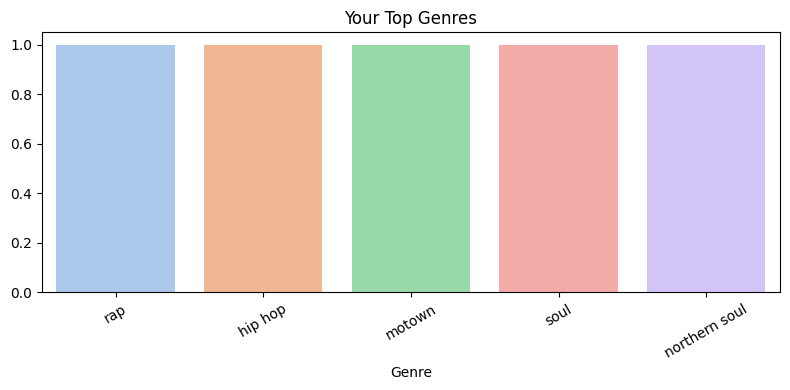

In [45]:
# Run this to display the dashboard
display_dashboard(sp)